In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dipole_moments.csv', 'potential_energy.csv', 'magnetic_shielding_tensors.csv', 'structures.csv', 'scalar_coupling_contributions.csv', 'structures', 'sample_submission.csv', 'mulliken_charges.csv', 'test.csv', 'train.csv']


In [2]:
import sys
!conda install --yes --prefix {sys.prefix} -c rdkit rdkit

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.5.15  |                0         133 KB
    openssl-1.0.2s             |       h7b6447c_0         3.1 MB
    rdkit-2018.09.1.0          |   py36h71b666b_1        20.2 MB  rdkit
    ------------------------------------------------------------
                                           Total:        23.5 MB

The following NEW packages will be INSTALLED:

  rdkit              rdkit/linux-64::rdkit-2018.09.1.0-py36h71b666b_1

The following packages will be UPDATED:

  ca-certificates                               2019.1.23-0 --> 2019.5.15-0
  openssl                                 1.0.2r-h7b6447c_0 --> 1.0.2s-h7b6447c_0



rdkit-2018.09.1.0    | 20.2 MB   | ##################################### | 100% 


In [3]:
%%bash -e
if ! [[ -f ./xyz2mol.py ]]; then
  wget https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
fi

--2019-06-10 04:58:46--  https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14228 (14K) [text/plain]
Saving to: ‘xyz2mol.py’

     0K .......... ...                                        100% 1.95M=0.007s

2019-06-10 04:58:46 (1.95 MB/s) - ‘xyz2mol.py’ saved [14228/14228]



In [4]:
# only reading 10% of data for debug
train = pd.read_csv('../input/train.csv')[::10]
test = pd.read_csv('../input/test.csv')[::10]

# Read molecules in RDKit using XYZ2MOL package

In [5]:
# rdkit & xyz2mol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
DrawingOptions.bondLineWidth=1.8
from rdkit.Chem.rdmolops import SanitizeFlags

# https://github.com/jensengroup/xyz2mol
from xyz2mol import xyz2mol, xyz2AC, AC2mol, read_xyz_file
from pathlib import Path
import pickle

CACHEDIR = Path('./')

def chiral_stereo_check(mol):
    # avoid sanitization error e.g., dsgdb9nsd_037900.xyz
    Chem.SanitizeMol(mol, SanitizeFlags.SANITIZE_ALL - SanitizeFlags.SANITIZE_PROPERTIES)
    Chem.DetectBondStereochemistry(mol,-1)
    # ignore stereochemistry for now
    #Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    #Chem.AssignAtomChiralTagsFromStructure(mol,-1)
    return mol

def xyz2mol(atomicNumList,charge,xyz_coordinates,charged_fragments,quick):
    AC,mol = xyz2AC(atomicNumList,xyz_coordinates)
    new_mol = AC2mol(mol,AC,atomicNumList,charge,charged_fragments,quick)
    new_mol = chiral_stereo_check(new_mol)
    return new_mol

def MolFromXYZ(filename):
    charged_fragments = True
    quick = True
    cache_filename = CACHEDIR/f'{filename.stem}.pkl'
    if cache_filename.exists():
        return pickle.load(open(cache_filename, 'rb'))
    else:
        try:
            atomicNumList, charge, xyz_coordinates = read_xyz_file(filename)
            mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)
            # commenting this out for kernel to work.
            # for some reason kernel runs okay interactively, but fails when it is committed.
            #pickle.dump(mol, open(cache_filename, 'wb'))
        except:
            print(filename)
    return mol

#mol = MolFromXYZ(xyzfiles[1])
#m = Chem.MolFromSmiles(Chem.MolToSmiles(mol, allHsExplicit=True)); m

from multiprocessing import Pool
from tqdm import *
from glob import glob

def MolFromXYZ_(filename):
    return filename.stem, MolFromXYZ(filename)

mols = {}
n_cpu = 4
with Pool(n_cpu) as p:
    molecule_names = np.concatenate([train.molecule_name.unique(), test.molecule_name.unique()])
    xyzfiles = [Path(f'../input/structures/{f}.xyz') for f in molecule_names]
    n = len(xyzfiles)
    with tqdm(total=n) as pbar:
        for res in p.imap_unordered(MolFromXYZ_, xyzfiles):
            mols[res[0]] = res[1]
            pbar.update()

100%|██████████| 130537/130537 [03:25<00:00, 634.50it/s]


# Visualize molecule using 2D diagram (hydrogen gets lost during smiles conversion)

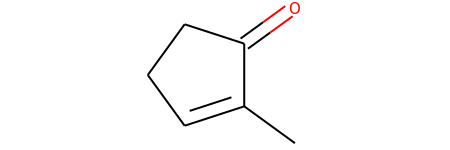

In [7]:
# visualize molecule using 2D diagram (hydrogen gets lost during smiles conversion)
m = mols['dsgdb9nsd_002129']
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m)); m_2d 

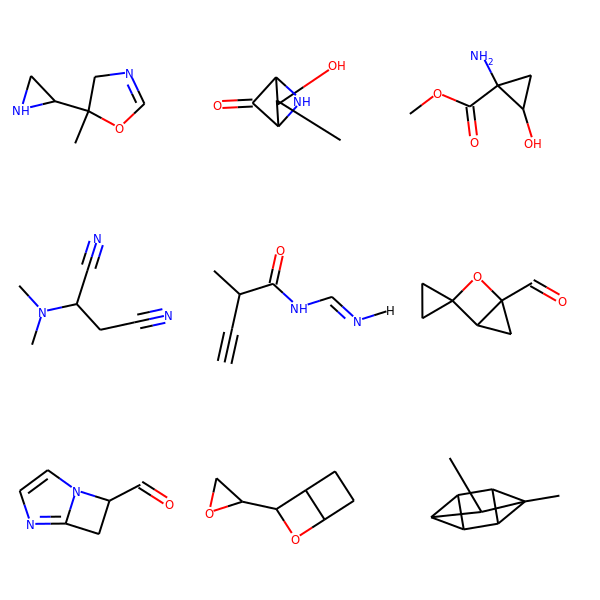

In [8]:
# 9 random molecules using rdkit grid
names = np.random.choice(list(mols.keys()), 9)
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mols[_])) for _ in names], molsPerRow=3)

## highlight the bond given in train/test

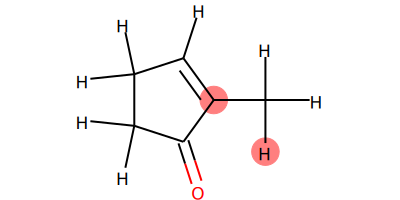

In [13]:
# highlight the bond given in train/test
# http://rdkit.blogspot.com/2015/02/new-drawing-code.html
m = mols['dsgdb9nsd_002129']
atom_index_0 = int(train[train.molecule_name == 'dsgdb9nsd_002129'].iloc[0].atom_index_0)
atom_index_1 = int(train[train.molecule_name == 'dsgdb9nsd_002129'].iloc[0].atom_index_1)
highlight = [atom_index_0, atom_index_1]

from IPython.display import SVG
Chem.rdDepictor.Compute2DCoords(m)
drawer = Draw.rdMolDraw2D.MolDraw2DSVG(400, 200)
drawer.DrawMolecule(m,highlightAtoms=highlight)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

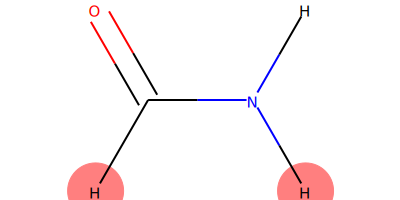

In [18]:
# 3JHH
row = train[train.type == '3JHH'].iloc[1]
m = mols[row.molecule_name]
atom_index_0 = int(row.atom_index_0)
atom_index_1 = int(row.atom_index_1)
highlight = [atom_index_0, atom_index_1]

from IPython.display import SVG
Chem.rdDepictor.Compute2DCoords(m)
drawer = Draw.rdMolDraw2D.MolDraw2DSVG(400, 200)
drawer.DrawMolecule(m,highlightAtoms=highlight)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

# prepare dataframe

In [28]:
from pathlib import Path
from sklearn import *
PATH = Path('../input')

# again, only using 5% of data for the committed kernel to work...
train = pd.read_csv(PATH/'train.csv')[::20]
test = pd.read_csv(PATH/'test.csv')[::20]

In [29]:
# https://www.kaggle.com/jazivxt/all-this-over-a-dog
train['atom1'] = train['type'].map(lambda x: str(x)[2])
train['atom2'] = train['type'].map(lambda x: str(x)[3])
test['atom1'] = test['type'].map(lambda x: str(x)[2])
test['atom2'] = test['type'].map(lambda x: str(x)[3])

In [30]:
lbl = preprocessing.LabelEncoder()
for i in range(4):
    train['type'+str(i)] = lbl.fit_transform(train['type'].map(lambda x: str(x)[i]))
    test['type'+str(i)] = lbl.transform(test['type'].map(lambda x: str(x)[i]))

In [31]:
structures = pd.read_csv(PATH/'structures.csv').rename(columns={'atom_index':'atom_index_0', 'x':'x0', 'y':'y0', 'z':'z0', 'atom':'atom1'})
train = pd.merge(train, structures, how='left', on=['molecule_name', 'atom_index_0', 'atom1'])
test = pd.merge(test, structures, how='left', on=['molecule_name', 'atom_index_0', 'atom1'])
del structures

In [32]:
structures = pd.read_csv(PATH/'structures.csv').rename(columns={'atom_index':'atom_index_1', 'x':'x1', 'y':'y1', 'z':'z1', 'atom':'atom2'})
train = pd.merge(train, structures, how='left', on=['molecule_name', 'atom_index_1', 'atom2'])
test = pd.merge(test, structures, how='left', on=['molecule_name', 'atom_index_1', 'atom2'])
del structures

# extract atom features

In [33]:
def feature_atom(atom):
    prop = {}
    nb = [a.GetSymbol() for a in atom.GetNeighbors()] # neighbor atom type symbols
    nb_h = sum([_ == 'H' for _ in nb]) # number of hydrogen as neighbor
    nb_o = sum([_ == 'O' for _ in nb]) # number of oxygen as neighbor
    nb_c = sum([_ == 'C' for _ in nb]) # number of carbon as neighbor
    nb_n = sum([_ == 'N' for _ in nb]) # number of nitrogen as neighbor
    nb_na = len(nb) - nb_h - nb_o - nb_n - nb_c
    prop['degree'] = atom.GetDegree()
    prop['hybridization'] = int(atom.GetHybridization())
    prop['inring'] = int(atom.IsInRing()) # is the atom in a ring?
    prop['inring3'] = int(atom.IsInRingSize(3)) # is the atom in a ring size of 3?
    prop['inring4'] = int(atom.IsInRingSize(4)) # is the atom in a ring size of 4?
    prop['inring5'] = int(atom.IsInRingSize(5)) # ...
    prop['inring6'] = int(atom.IsInRingSize(6))
    prop['inring7'] = int(atom.IsInRingSize(7))
    prop['inring8'] = int(atom.IsInRingSize(8))
    prop['nb_h'] = nb_h
    prop['nb_o'] = nb_o
    prop['nb_c'] = nb_c
    prop['nb_n'] = nb_n
    prop['nb_na'] = nb_na
    return prop

In [34]:
# atom feature of dsgdb9nsd_002129 atom_index_0
molecule_name = 'dsgdb9nsd_002129'
row = train[train.molecule_name == molecule_name].iloc[0]
atom_index_0 = int(row.atom_index_0)
atom_index_1 = int(row.atom_index_1)
m = MolFromXYZ(PATH/f'structures/{molecule_name}.xyz')
a0 = m.GetAtomWithIdx(atom_index_0)
feature_atom(a0)

{'degree': 1,
 'hybridization': 1,
 'inring': 0,
 'inring3': 0,
 'inring4': 0,
 'inring5': 0,
 'inring6': 0,
 'inring7': 0,
 'inring8': 0,
 'nb_h': 0,
 'nb_o': 0,
 'nb_c': 1,
 'nb_n': 0,
 'nb_na': 0}

In [35]:
a1 = m.GetAtomWithIdx(atom_index_1)
feature_atom(a1)

{'degree': 3,
 'hybridization': 3,
 'inring': 1,
 'inring3': 0,
 'inring4': 0,
 'inring5': 1,
 'inring6': 0,
 'inring7': 0,
 'inring8': 0,
 'nb_h': 1,
 'nb_o': 0,
 'nb_c': 2,
 'nb_n': 0,
 'nb_na': 0}

In [36]:
# extract some simple atomic feature for atom_index_0 and atom_index_1

# use cached rdkit mol object to save memory
if 'mols' in locals(): del mols
import gc
gc.collect()

# fix atom bonds
# dsgdb9nsd_059827: hydrogen has is far apart
nblist = {
    'dsgdb9nsd_059827': {
        13: 3
    }
}

def _features(args):
    idx, row = args
    molecule_name = row.molecule_name
    atom_index_0 = int(row.atom_index_0)
    atom_index_1 = int(row.atom_index_1)
    
    prop = {'molecule_name': molecule_name,
            'atom_index_0': atom_index_0,
            'atom_index_1': atom_index_1}

    # atom_0 is always hydrogen
    m = MolFromXYZ(PATH/f'structures/{molecule_name}.xyz') # less memory intensive in multiprocessing.Pool
    a0 = m.GetAtomWithIdx(atom_index_0)

    a1 = m.GetAtomWithIdx(atom_index_1)
    a1_prop = feature_atom(a1)
    prop.update({'a1_'+k: a1_prop[k] for k in a1_prop.keys()})

    # skipping below for time constraint
    # neighbor of atom_0
    try:
        a0_nb_idx = [a.GetIdx() for a in a0.GetNeighbors() if a.GetIdx() != a0].pop()
    except:
        if molecule_name in nblist and atom_index_0 in nblist[molecule_name]:
            a0_nb_idx = nblist[molecule_name][atom_index_0]
        else:
            print(molecule_name)
            print(row)

    a0_nb = m.GetAtomWithIdx(a0_nb_idx)
    a0_nb_prop = feature_atom(a0_nb)
    for k in a0_nb_prop.keys():
        prop['a0_nb_'+k] = a0_nb_prop[k]
        
    c = m.GetConformer()
    #prop['dist_a0_a0_nb'] = np.linalg.norm(c.GetAtomPosition(atom_index_0) - c.GetAtomPosition(a0_nb_idx))
    prop['x_a0_nb'] = c.GetAtomPosition(a0_nb_idx)[0]
    prop['y_a0_nb'] = c.GetAtomPosition(a0_nb_idx)[1]
    prop['z_a0_nb'] = c.GetAtomPosition(a0_nb_idx)[2]

    # neighbor of atom_1
    try:
        a1_nb_idx = [a.GetIdx() for a in a1.GetNeighbors() if a.GetIdx() != a1].pop()
    except:
        if molecule_name in nblist and atom_index_1 in nblist[molecule_name]:
            a1_nb_idx = nblist[molecule_name][atom_index_1]
        else:
            print(molecule_name)
            print(row)
    a1_nb = m.GetAtomWithIdx(a1_nb_idx)
    a1_nb_prop = feature_atom(a1_nb)
    for k in a1_nb_prop.keys():
        prop['a1_nb_'+k] = a1_nb_prop[k]
    prop['x_a1_nb'] = c.GetAtomPosition(a1_nb_idx)[0]
    prop['y_a1_nb'] = c.GetAtomPosition(a1_nb_idx)[1]
    prop['z_a1_nb'] = c.GetAtomPosition(a1_nb_idx)[2]
    #prop['dist_a1_a1_nb'] = np.linalg.norm(c.GetAtomPosition(a1.GetIdx()) - c.GetAtomPosition(a1_nb.GetIdx()))
    #prop['dist_a0_a1_nb'] = np.linalg.norm(c.GetAtomPosition(a0.GetIdx()) - c.GetAtomPosition(a1_nb.GetIdx()))
    #prop['dist_a1_a0_nb'] = np.linalg.norm(c.GetAtomPosition(a1.GetIdx()) - c.GetAtomPosition(a0_nb.GetIdx()))
    return prop

def features(df):
    prop = []
    n_cpu = 4
    with Pool(n_cpu) as p:
        n = len(df)
        res = _features((0, df.iloc[0]))
        keys = res.keys()
        _df = df[['molecule_name', 'atom_index_0', 'atom_index_1']]
        with tqdm(total=n) as pbar:
            for res in p.imap_unordered(_features, _df.iterrows()):
                # this is faster than using dict
                prop.append([res[_] for _ in keys])
                pbar.update()
        del _df
    
    prop = pd.DataFrame.from_records(prop, columns=keys)
    df = pd.merge(df, prop, how='left', on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df

train = features(train)
test = features(test)

100%|██████████| 125278/125278 [03:32<00:00, 589.77it/s]


In [37]:
train.drop(columns=['id', 'molecule_name', 'atom1', 'atom2', 'atom_index_0', 'atom_index_1'], inplace=True)
test.drop(columns=['molecule_name', 'atom1', 'atom2', 'atom_index_0', 'atom_index_1'], inplace=True)

In [38]:
#https://www.kaggle.com/artgor/molecular-properties-eda-and-models
train_p0 = train[['x0', 'y0', 'z0']].values
train_p1 = train[['x1', 'y1', 'z1']].values
test_p0 = test[['x0', 'y0', 'z0']].values
test_p1 = test[['x1', 'y1', 'z1']].values

train['dist'] = np.linalg.norm(train_p0 - train_p1, axis=1)
test['dist'] = np.linalg.norm(test_p0 - test_p1, axis=1)

train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')
del train_p0, train_p1
del test_p0, test_p1

In [39]:
col = [c for c in train.columns if c not in ['scalar_coupling_constant']]
reg = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=20, random_state=4, verbose=1)

In [40]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train[col], train['scalar_coupling_constant'], test_size=0.2)

In [41]:
reg.fit(X_train.drop(['type'], axis=1), y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   23.6s finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
          oob_score=False, random_state=4, verbose=1, warm_start=False)

In [42]:
# https://www.kaggle.com/uberkinder/efficient-metric
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [43]:
y_pred = reg.predict(X_valid.drop('type', axis=1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.3s finished


In [44]:
group_mean_log_mae(y_valid, y_pred, X_valid.type)

-0.1558727455167723

I'm kind of new to Kaggle kernel. Let me know if you have any comment/suggestion. 

I do not like using features directly derived from XYZ coordinates from atoms (e.g., min/max/std XYZ). In my view, they are not physically meaningful, so I tried to avoid it here. Though it is interesting some of the kernels heavily rely on those features do well.